In [ ]:
# import system libs
import os
import itertools

# import data handling tools
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet50 import ResNet50
from keras.applications import VGG16

# ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 76 bytes


In [ ]:
!kaggle datasets download -d nazmul0087/ct-kidney-dataset-normal-cyst-tumor-and-stone

 98% 1.49G/1.52G [00:16<00:00, 40.1MB/s]
100% 1.52G/1.52G [00:16<00:00, 96.2MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/ct-kidney-dataset-normal-cyst-tumor-and-stone.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# Create directories for each class

normal_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal']
stone_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone']
tumor_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor']
cyst_dir = ['/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst']

directory_list = [normal_dir, stone_dir, tumor_dir, cyst_dir]
labels_list = ['Normal', 'Stone', 'Tumor', 'Cyst']

In [ ]:
filepaths = []
labels = []

for i, dir_list in enumerate(directory_list):
    for j in dir_list:
        klist = os.listdir(j)
        for k in klist:
            kpath = os.path.join(j,k)

            filepaths.append(kpath)
            labels.append(labels_list[i])

file_series = pd.Series(filepaths, name = 'filepath')
label_series = pd.Series(labels, name = 'labels')
kidney_data = pd.concat([file_series, label_series], axis =1)
kidney_df = pd.DataFrame(kidney_data)
print(kidney_df.head())
print(kidney_df["labels"].value_counts())

                                            filepath  labels
0  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
1  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
2  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
3  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
4  /content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-S...  Normal
labels
Normal    5077
Cyst      3709
Tumor     2283
Stone     1377
Name: count, dtype: int64


In [ ]:
print("Shape of kidney dataframe is:" , kidney_df.shape)

Shape of kidney dataframe is: (12446, 2)


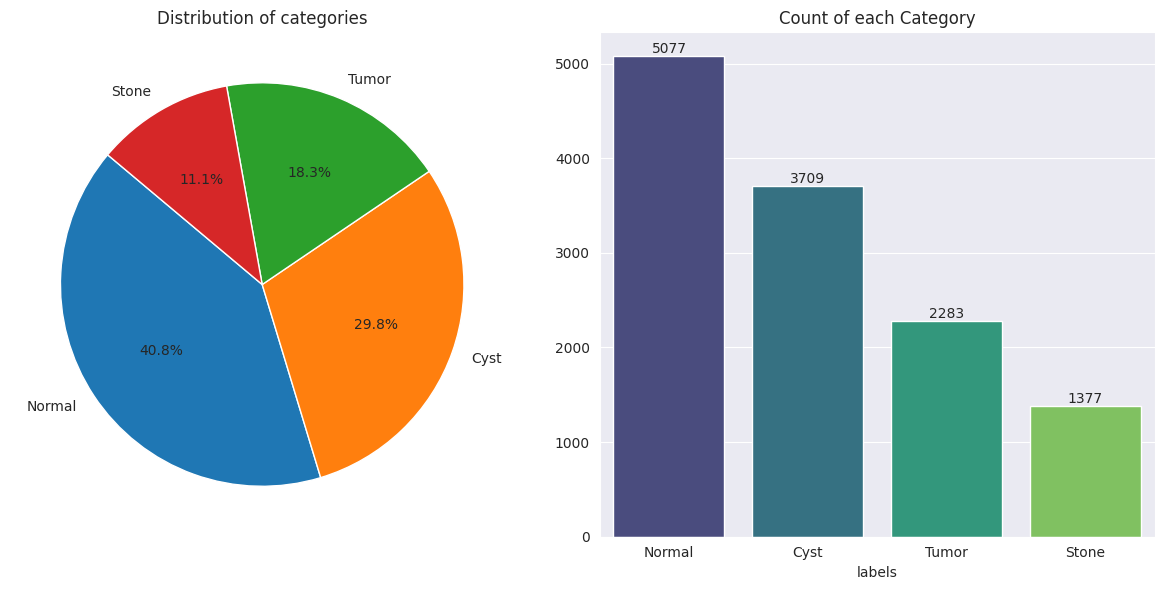

In [ ]:
#Count the occurences of each category in the "category" column
#The erro was that I named my label "Label"
count = kidney_df['labels'].value_counts()
#We are separating them into Normal and Pneumonia

#Creating a subplot with two subplots
fig, axs = plt.subplots(1, 2, figsize = (12,6), facecolor = 'white')

#Plot the pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels = count.index, autopct = '%1.1f%%', startangle = 140)
axs[0].set_title('Distribution of categories')

#Plot the bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax = axs[1], palette = 'viridis')
axs[1].set_title('Count of each Category')

# Display numerical values on top of the bars
for i, val in enumerate(count.values):
    axs[1].text(i, val, str(val), ha='center', va='bottom')

#Adjust the Layot
plt.tight_layout()

#Print the plot

plt.show()

In [ ]:
train_df, test_images = train_test_split(kidney_df, train_size = 0.7, shuffle = True, random_state = 42)
test_df, valid_df = train_test_split(test_images, train_size = 0.5, shuffle = True, random_state = 42)

print(train_df.shape)
print(test_images.shape)
print(test_df.shape)
print(valid_df.shape)
#Shape = (rows,columns)

(8712, 2)
(3734, 2)
(1867, 2)
(1867, 2)


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0,1]
    featurewise_center=True,  # normalize pixel values to have mean 0
    featurewise_std_normalization=True,  # normalize pixel values to have std 1
    rotation_range=40,  # randomly rotate images in the range (0-40 degrees)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    zoom_range=0.2,  # randomly zoom into images
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True,  # randomly flip images vertically

)
Datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to range [0,1]
    featurewise_center=True,  # normalize pixel values to have mean 0
    featurewise_std_normalization=True,  # normalize pixel values to have std 1
    rotation_range=0,  # randomly rotate images in the range (0-40 degrees)
    width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0,  # randomly shift images vertically (fraction of total height)
    zoom_range=0,  # randomly zoom into images
    horizontal_flip=False,  # randomly flip images horizontally
    vertical_flip=False,  # randomly flip images vertically
)
# Define the DataFrame with file paths and labels
# Modify this according to your actual DataFrame structure

# Define target image size
target_size = (244,244)  # adjust according to your desired image size

# Create a DirectoryIterator
# Assuming you have a directory structure with images, and 'filename' column contains relative paths to these images
# Modify the 'directory' parameter according to your actual directory structure
# 'x_col' parameter specifies the column in the DataFrame containing file paths
# 'y_col' parameter specifies the column in the DataFrame containing labels
# 'class_mode' parameter specifies the type of labels, 'binary' for binary classification, 'categorical' for multi-class classification, etc.
# 'batch_size' parameter specifies the batch size for training
# 'shuffle' parameter specifies whether to shuffle the data
# 'seed' parameter specifies the random seed for shuffling
# 'color_mode' parameter specifies the color mode of the images, 'grayscale' for grayscale, 'rgb' for RGB
# 'target_size' parameter specifies the target image size
# 'validate_filenames' parameter specifies whether to validate image filenames
# 'image_data_generator' parameter specifies the ImageDataGenerator object for preprocessing
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='labels',
    class_mode='categorical',  # adjust according to your classification task
    batch_size=32,
    shuffle=True,
    seed=42,
    color_mode='rgb',
    target_size=target_size,
    validate_filenames=True  # set to True if you want to validate image filenames
)
valid_generator = Datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='filepath',
    y_col='labels',
    class_mode='categorical',  # adjust according to your classification task
    batch_size=32,
    shuffle= False,
    color_mode='rgb',
    target_size=target_size,
    validate_filenames=False  # set to True if you want to validate image filenames
)
test_generator = Datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='labels',
    class_mode='categorical',  # adjust according to your classification task
    batch_size=32,
    shuffle=False,
    color_mode='rgb',
    target_size=target_size,
    validate_filenames=False  # set to True if you want to validate image filenames
)

Found 8712 validated image filenames belonging to 4 classes.
Found 1867 non-validated image filenames belonging to 4 classes.
Found 1867 non-validated image filenames belonging to 4 classes.


In [ ]:
for image_batch, labels_batch in train_generator:
    print ("Shape of X train: ", image_batch.shape)
    print ("Shape of Y train: ", image_batch.shape)
    break
for image_batch, labels_batch in valid_generator:
    print ("Shape of X validation: ", image_batch.shape)
    print ("Shape of Y validation: ", image_batch.shape)
    break
for image_batch, labels_batch in test_generator:
    print ("Shape of X test: ", image_batch.shape)
    print ("Shape of Y test: ", image_batch.shape)
    break

Shape of X train:  (32, 244, 244, 3)
Shape of Y train:  (32, 244, 244, 3)
Shape of X validation:  (32, 244, 244, 3)
Shape of Y validation:  (32, 244, 244, 3)
Shape of X test:  (32, 244, 244, 3)
Shape of Y test:  (32, 244, 244, 3)


In [ ]:
import os

# Path to the directory containing the kidney dataset
data_dir = '/content/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

# Check if the directory exists
if os.path.exists(data_dir):
    # List all directories in the dataset directory
    subfolders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

    # Print the list of subfolders (classes)
    print("Subfolders (classes) in the directory:")
    for cls in subfolders:
        print(cls)
else:
    print("Directory not found:", data_dir)


Subfolders (classes) in the directory:
Tumor
Cyst
Stone
Normal


In [ ]:
classes=list(train_generator.class_indices.keys())
print ("The training classes are:", classes)
classes=list(valid_generator.class_indices.keys())
print ("The validation classes are:",classes)
classes=list(test_generator.class_indices.keys())
print ("The testing classes are:",classes)

The training classes are: ['Cyst', 'Normal', 'Stone', 'Tumor']
The validation classes are: ['Cyst', 'Normal', 'Stone', 'Tumor']
The testing classes are: ['Cyst', 'Normal', 'Stone', 'Tumor']


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def model_performance(history):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    Epochs = range(1, len(tr_acc) + 1)

    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def model_evaluation(model, test_data):
    test_loss, test_accuracy = model.evaluate(test_data)
    print("Test Loss: ", test_loss)
    print("Test Accuracy: ", test_accuracy)

def plot_confusion_matrix(model, test_data, class_names):
    # Get Predictions
    preds = model.predict(test_data)
    y_pred = np.argmax(preds, axis=1)
    y_true = np.concatenate([y for x, y in test_data], axis=0)

    # Display the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, concatenate, AveragePooling2D, Dropout, Flatten, Dense
from keras.models import Model

def inception_module(x, filters):
    # 1x1 convolution
    conv_1x1 = Conv2D(filters=filters[0], kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(x)

    # 3x3 convolution
    conv_3x3 = Conv2D(filters=filters[1], kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(x)

    # 5x5 convolution
    conv_5x5 = Conv2D(filters=filters[2], kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu')(x)

    # Max pooling
    max_pool = MaxPooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(x)

    # Concatenate the outputs
    return concatenate([conv_1x1, conv_3x3, conv_5x5, max_pool], axis=-1)

# Input layer
input_layer = Input(shape=(224, 224, 3))

# Stem
stem = Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
stem = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(stem)
stem = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='relu')(stem)
stem = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu')(stem)
stem = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(stem)

# Inception modules
inception1 = inception_module(stem, filters=[64, 96, 128])
inception2 = inception_module(inception1, filters=[128, 128, 192])

# Global average pooling
avg_pool = AveragePooling2D(pool_size=(7, 7), strides=(1, 1), padding='valid')(inception2)

# Flatten
flatten = Flatten()(avg_pool)

# Dense layers
dense1 = Dense(units=1024, activation='relu')(flatten)
dropout1 = Dropout(0.4)(dense1)
dense2 = Dense(units=4, activation='softmax')(dropout1)

# Create the model
mobilenet = Model(inputs=input_layer, outputs=dense2)

# Compile the model
mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
mobilenet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 56, 56, 64)           4160      ['max_pooling2d[0][0]']   

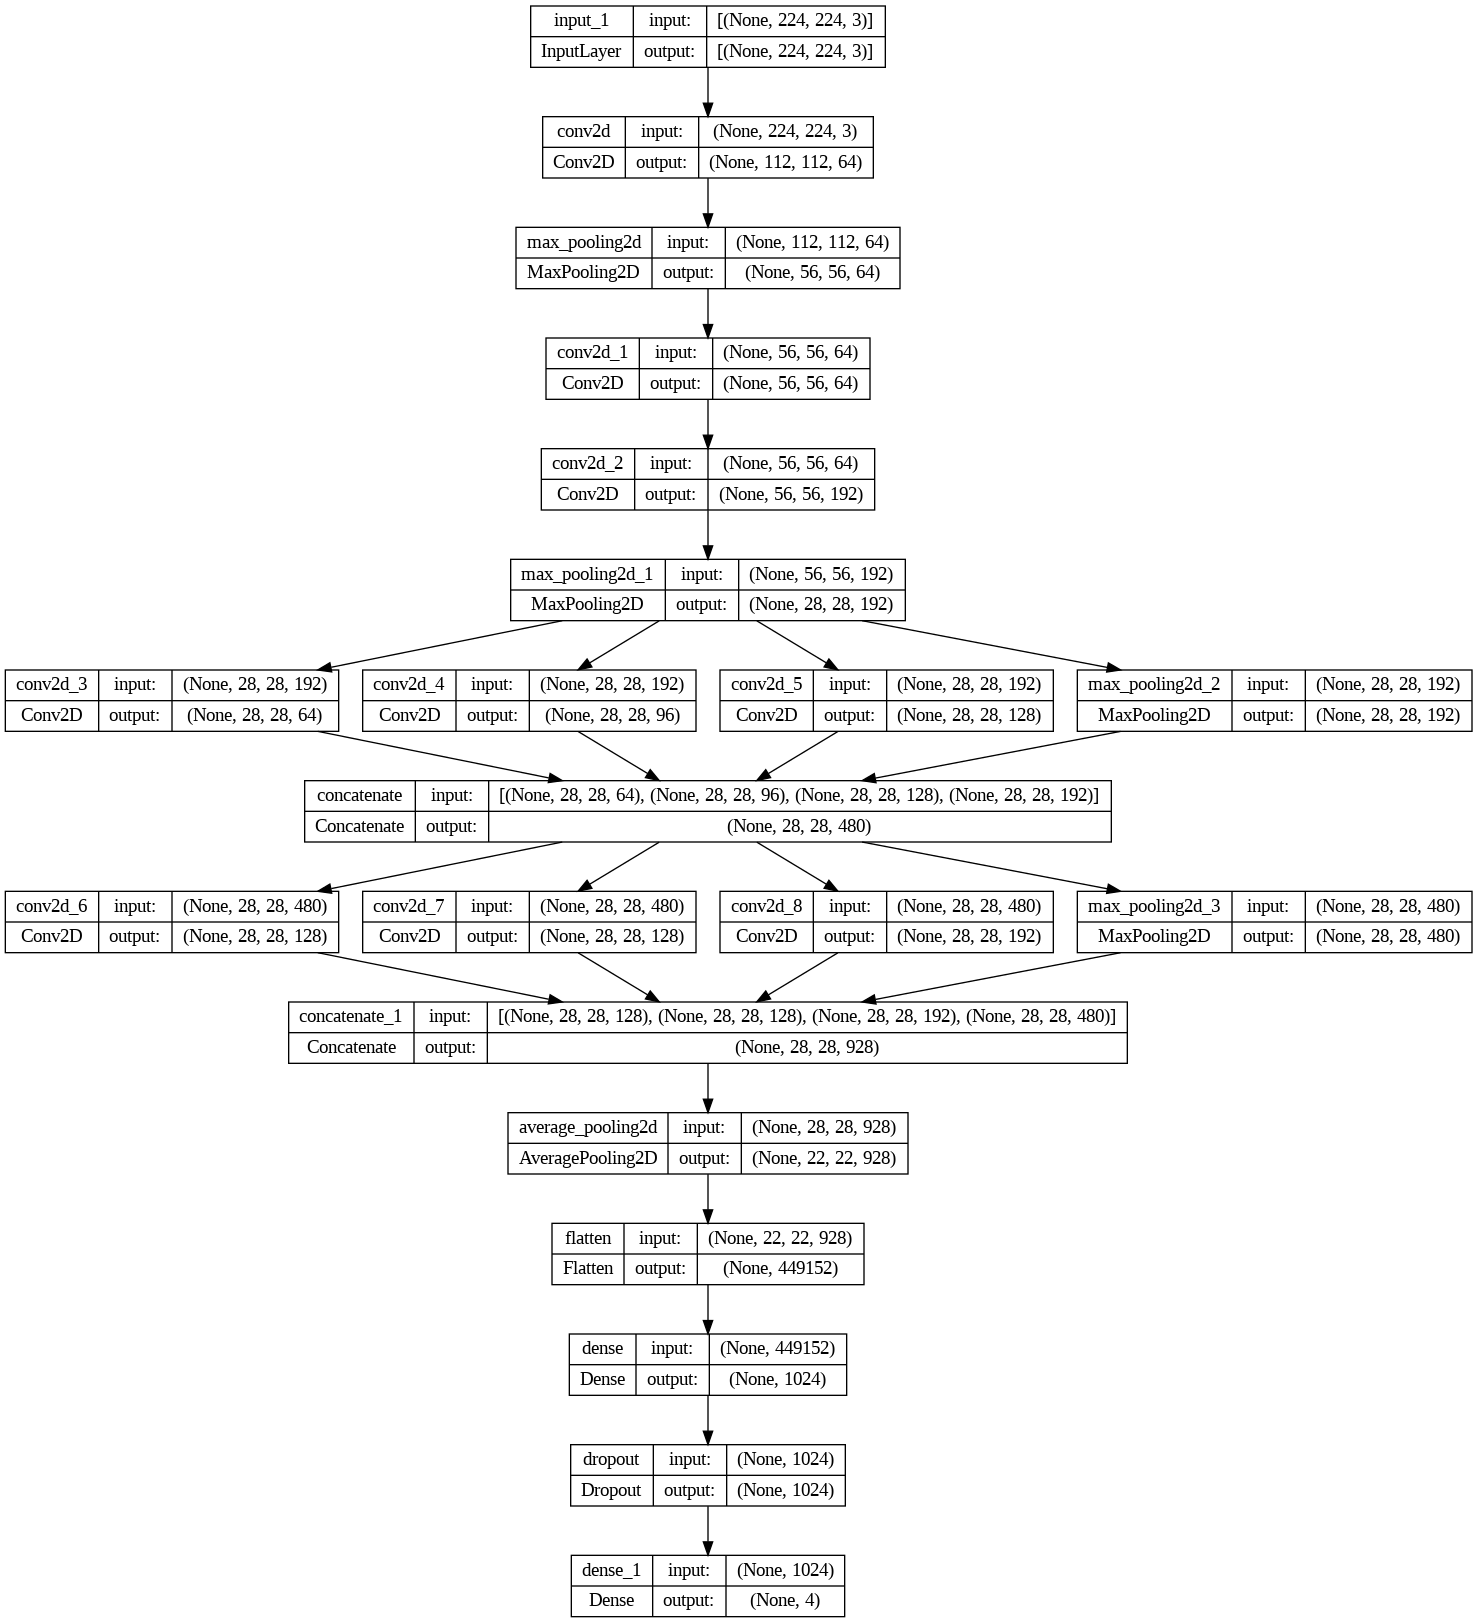

In [ ]:
from keras.utils import plot_model

# Assuming you have already defined the 'mobilenet' model
plot_model(mobilenet, to_file='mobilenet_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

# Define the MobileNet model
model = Sequential([
    Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),

    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),

    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),
    Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same"),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(learning_rate=0.01),
    metrics=['accuracy']
)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define number of epochs
epochs = 100

# Train the model with early stopping
history = model.fit(train_generator, epochs=epochs, validation_data=valid_generator, callbacks=[early_stopping], verbose=1)


Epoch 1/100
273/273 [==============================] - 182s 605ms/step - loss: 1.1088 - accuracy: 0.6121 - val_loss: 1.9419 - val_accuracy: 0.2967
Epoch 2/100
273/273 [==============================] - 162s 592ms/step - loss: 0.7318 - accuracy: 0.7062 - val_loss: 1.3046 - val_accuracy: 0.4049
Epoch 3/100
273/273 [==============================] - 161s 590ms/step - loss: 0.6405 - accuracy: 0.7435 - val_loss: 0.5424 - val_accuracy: 0.7852
Epoch 4/100
273/273 [==============================] - 162s 593ms/step - loss: 0.5490 - accuracy: 0.7844 - val_loss: 0.4227 - val_accuracy: 0.8511
Epoch 5/100
273/273 [==============================] - 160s 584ms/step - loss: 0.4942 - accuracy: 0.8088 - val_loss: 0.5105 - val_accuracy: 0.8479
Epoch 6/100
273/273 [==============================] - 160s 586ms/step - loss: 0.4233 - accuracy: 0.8374 - val_loss: 0.4602 - val_accuracy: 0.8040
Epoch 7/100
273/273 [==============================] - 159s 584ms/step - loss: 0.3892 - accuracy: 0.8507 - val_loss: 0

In [ ]:
class_names = ['Cyst', 'Stone', 'Normal', 'Tumor']  # Replace with actual class names
plot_confusion_matrix(model, test_generator, class_names=class_names)
model_evaluation(model, test_generator)


59/59 [==============================] - 9s 135ms/step


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming model is your trained model and test_generator is your test data generator

# Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Get the predicted labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' average depending on your preference
recall = recall_score(y_true, y_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' average depending on your preference
f1 = f1_score(y_true, y_pred_labels, average='weighted')  # Use 'micro', 'macro', or 'weighted' average depending on your preference

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


59/59 [==============================] - 9s 148ms/step
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


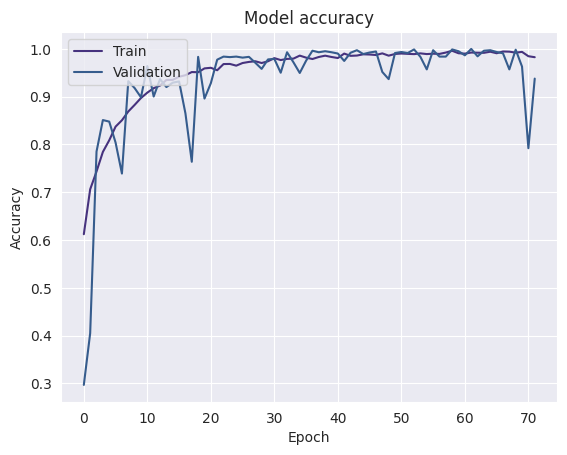

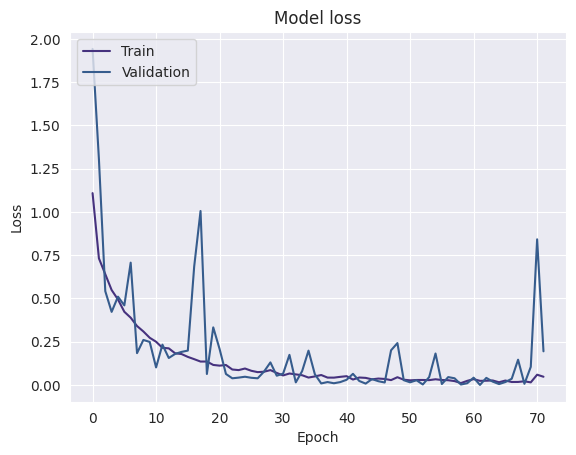

59/59 [==============================] - 8s 137ms/step - loss: 6.6192e-04 - accuracy: 1.0000
Test Loss: 0.0006619229097850621
Test Accuracy: 1.0
59/59 [==============================] - 8s 138ms/step


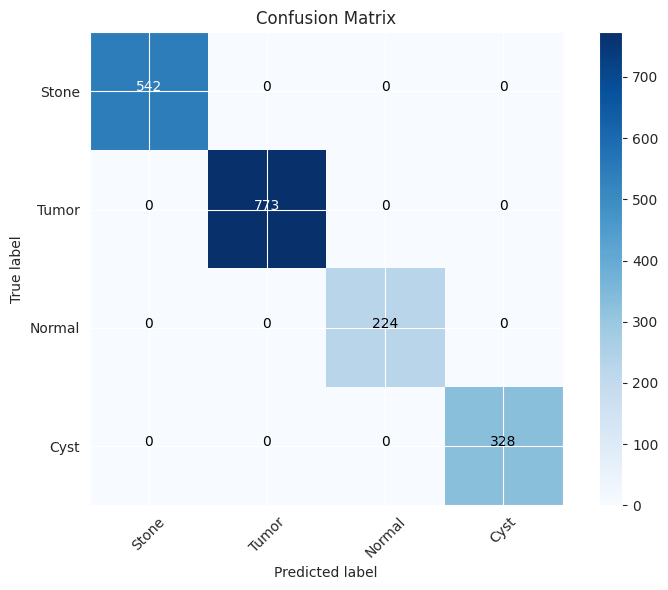

59/59 [==============================] - 8s 140ms/step
              precision    recall  f1-score   support

       Stone       1.00      1.00      1.00       542
       Tumor       1.00      1.00      1.00       773
      Normal       1.00      1.00      1.00       224
        Cyst       1.00      1.00      1.00       328

    accuracy                           1.00      1867
   macro avg       1.00      1.00      1.00      1867
weighted avg       1.00      1.00      1.00      1867



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(model, test_generator, class_names):
    # Generate predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    true_classes = test_generator.classes

    # Generate confusion matrix
    cm = confusion_matrix(true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Function to plot loss and accuracy
def plot_loss_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Function to evaluate model performance
def model_performance(history, model, test_generator, class_names):
    # Plot loss and accuracy
    plot_loss_accuracy(history)

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_accuracy)

    # Plot confusion matrix
    plot_confusion_matrix(model, test_generator, class_names)

    # Generate predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    true_classes = test_generator.classes

    # Generate classification report
    report = classification_report(true_classes, y_pred_classes, target_names=class_names)
    print(report)

# Define class names
class_names = ['Stone', 'Tumor', 'Normal', 'Cyst']  # Replace with actual class names

# Call the function to train and evaluate the model
model_performance(history, model, test_generator, class_names)


ValueError: Exception encountered when calling layer "tf.__operators__.add_1" (type TFOpLambda).

Dimensions must be equal, but are 3 and 256 for '{{node tf.__operators__.add_1/AddV2}} = AddV2[T=DT_FLOAT](Placeholder, Placeholder_1)' with input shapes: [?,64,3], [?,1,64,256].

Call arguments received by layer "tf.__operators__.add_1" (type TFOpLambda):
  • x=tf.Tensor(shape=(None, 64, 3), dtype=float32)
  • y=tf.Tensor(shape=(None, 1, 64, 256), dtype=float32)
  • name=None

ValueError: Exception encountered when calling layer "tf.__operators__.add_3" (type TFOpLambda).

Dimensions must be equal, but are 3 and 256 for '{{node tf.__operators__.add_3/AddV2}} = AddV2[T=DT_FLOAT](Placeholder, Placeholder_1)' with input shapes: [?,224,224,3], [?,1,224,224,256].

Call arguments received by layer "tf.__operators__.add_3" (type TFOpLambda):
  • x=tf.Tensor(shape=(None, 224, 224, 3), dtype=float32)
  • y=tf.Tensor(shape=(None, 1, 224, 224, 256), dtype=float32)
  • name=None